# Setting up Hyperparameters

In [ ]:
epochs = 5
negative_mining = False
soft_labels = False
nb_augment = 0
load_data_on_GPU = True

In [ ]:
batch_size = 3
learning_rate = 1e-4

### Selecting the correct device for training (CPU or GPU)

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Importing the Data

In [ ]:
from dataset import POCDataReader, data_augment_

data_reader = POCDataReader(root_dir="../data/POC", load_on_gpu=False, limit=100, verbose=True)

train_data, val_data, test_data = data_reader.split([0.7, 0.1, 0.2])

data_augment_(train_data, n=nb_augment, load_on_gpu=False, verbose=True)

In [ ]:
from torch.nn import Sequential
from torchvision.transforms.functional import invert
from torch.nn.functional import normalize

from pipelines import InputPipeline, SumFilters
from pipelines.filters import *


sumFilter = SumFilters(FrangiFilter(), SatoFilter())
crackBinFilter = Sequential(FrangiFilter(), CrackBinaryFilter())
bgBinFilter = Sequential(FrangiFilter(), BGBinaryFilter(60.))
skeletonFilter = SkeletonFilter(crackBinFilter)
watershedFilter = WatershedFilter(background_filter=bgBinFilter, foreground_filter=skeletonFilter)

inpip = InputPipeline(
    transformer=None,
    layer_transformer=[
#         FrangiFilter(),
#         SatoFilter(),
#         sumFilter,
#         crackBinFilter,
#         bgBinFilter,
        skeletonFilter,
#         watershedFilter,
    ]
)

inpip = inpip.to(device)

### Creating Training Dataset

In [ ]:
from torch.nn.functional import normalize
from torchvision.transforms import GaussianBlur

from dataset import POCDataset

train_dataset = POCDataset(
    train_data,
    transform=inpip,
    target_transform= GaussianBlur(kernel_size=3, sigma=0.7) if soft_labels else None,
    negative_mining=negative_mining,
    load_on_gpu=load_data_on_GPU,
    verbose=True
)

# train_dataset.precompute_transform(verbose=True)

In [ ]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.sampler,
        shuffle= True if train_dataset.sampler is None else None,
    )
else:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.sampler,
        shuffle= True if train_dataset.sampler is None else None,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Creating Validation Dataset

In [ ]:
from dataset import POCDataset

val_dataset = POCDataset(val_data, transform=inpip, target_transform=None, negative_mining=False)

In [ ]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size= 2 * batch_size,
        shuffle=True,
    )
else:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size= 2 * batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Creating Evaluation Dataset

In [ ]:
from dataset import POCDataset

test_dataset = POCDataset(test_data, transform=inpip, target_transform=None, negative_mining=False)

In [ ]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
    )
else:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Testing the dataloader

In [ ]:
from my_utils import show_img

features, masks, files, indexes = next(iter(training_dataloader))
print(features.size(), masks.size())

show_img(features)
show_img(masks)
print(files, indexes)

### Testing Dataset for proportion between classes

In [ ]:
_,train_labels,_,_ = next(iter(training_dataloader))

nb_pixel = torch.unique(train_labels, return_counts=True)[1]
print("Proportion of class 1 in this batch: {}%".format(nb_pixel[1] * 100 / (nb_pixel[0] + nb_pixel[1])))

Result is usually around 1.1% which may be too low for cross_entropy_loss.

# Building the differents modules

## Creating the models

#### Using Unet with bilinear upsampling and cropping to generate 2 classes (background and crack).

In [ ]:
from models import UNet, DeepCrack, SubUNet

# model = UNet(n_channels=1, n_classes=2, bilinear=True, crop=False).to(device)
# model = DeepCrack(n_channels=inpip.nb_channel, n_classes=2).to(device)
model = SubUNet(n_channels=inpip.nb_channel, n_classes=2).to(device)

In [ ]:
print("Total number of parameters: {0:,}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
print(f"Model structure: {model}")

## Creating the loss functions

#### Bordered (Focal + Tversky) Loss

In [ ]:
import torch
from loss import BorderedLoss, TverskyLoss, FocalLoss

weight = torch.tensor([.3, .7])

loss_fn = BorderedLoss(
    border_loss=FocalLoss(weight=weight, gamma=2),
    volume_loss=TverskyLoss(alpha=0.3, beta=0.7),
    ratio=0.5).to(device)

## Creating the Optimizer

In [ ]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))

## Setting up the Learning Rate Scheduler

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

## Creating the Metrics

In [ ]:
from metrics import Metrics, EvaluationMetrics


train_metrics = Metrics(
    buffer_size=len(training_dataloader),
    mode="Training",
    hyperparam={
        'Network': model.__class__,
        'Optimizer': optimizer.__class__,
        'Loss Function': loss_fn,
        'Input Pipeline': inpip,
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
        'Negative Mining': negative_mining,
        'Smooth Labeling': soft_labels,
    },
    device=device)

val_metrics = Metrics(
    buffer_size=len(validation_dataloader),
    mode="Validation",
    hyperparam={
        'Network': model.__class__,
        'Optimizer': optimizer.__class__,
        'Loss Function': loss_fn,
        'Input Pipeline': inpip,
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
        'Negative Mining': negative_mining,
        'Smooth Labeling': soft_labels,
    },
    device=device)

test_metrics = EvaluationMetrics(
    buffer_size=len(evaluation_dataloader),
    hyperparam={
        'Network': model.__class__,
        'Optimizer': optimizer.__class__,
        'Loss Function': loss_fn,
        'Input Pipeline': inpip,
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
        'Negative Mining': negative_mining,
        'Smooth Labeling': soft_labels,
    },
    epochs=epochs,
    device=device)

# Training, testing and validating the Model

In [ ]:
from train_tqdm import training_loop, validation_loop, evaluation_loop

for epoch in range(1, epochs+1):
    training_loop(epoch, training_dataloader, model, loss_fn, optimizer, lr_scheduler, train_metrics, device)
    validation_loop(epoch, validation_dataloader, model, loss_fn, val_metrics, device)

evaluation_loop(evaluation_dataloader, model, test_metrics, device)

train_metrics.close_tensorboard()
val_metrics.close_tensorboard()
test_metrics.close_tensorboard()

In [121]:
from torchvision.io import read_image

prediction = read_image(path="../data/thickness_eval/crack_mask/KakaoTalk_20221104_113024634_05--11.jpg")
prediction = prediction[0:1]
prediction = prediction > 200

torch.Size([1, 442, 442]) tensor([False,  True])


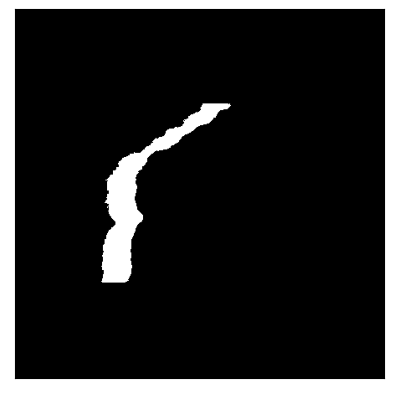

In [122]:
from my_utils import show_img

print(prediction.size(), prediction.unique())

show_img(prediction.unsqueeze(0))

In [123]:
numpy_array = prediction[0].bool().cpu().numpy()

In [124]:
from skimage.morphology import skeletonize

sk_array = skeletonize(numpy_array)

In [125]:
from scipy.ndimage import distance_transform_edt

dt_array = distance_transform_edt(numpy_array)

In [126]:
import numpy

dt_array /= numpy.amax(dt_array)

dist_skel = sk_array + dt_array

In [127]:
dist_skel = dist_skel > 1.5

In [128]:
import torch

sk_tensor = torch.from_numpy(dist_skel)
invert_bin_mask = torch.from_numpy(~numpy_array)

torch.Size([442, 442]) tensor([False,  True])


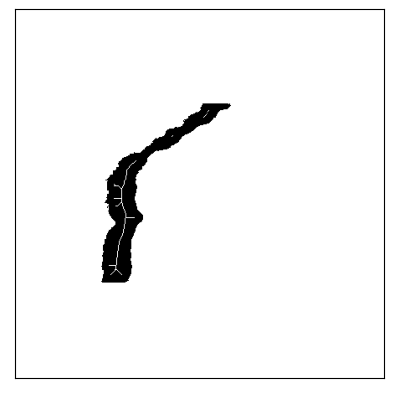

In [129]:
from my_utils import show_img

img = sk_tensor + invert_bin_mask

print(img.size(), img.unique())
show_img(img.unsqueeze(0).unsqueeze(0))

In [130]:
from skimage.metrics import hausdorff_distance

hd_dist = hausdorff_distance(dist_skel, numpy_array)
print(hd_dist)

26.68332812825267


In [131]:
dist_skel_ind = list(zip(*dist_skel.nonzero()))
numpy_array_ind = list(zip(*(~numpy_array).nonzero()))

In [132]:
from scipy.spatial.distance import directed_hausdorff

dist, ind1, ind2 = directed_hausdorff(dist_skel_ind, numpy_array_ind)

print(dist)

17.46424919657298


In [133]:
x1 = dist_skel_ind[ind1]
x2 = numpy_array_ind[ind2]

In [134]:
from skimage.metrics import hausdorff_pair

hd_pairs = hausdorff_pair(dist_skel, numpy_array)

In [135]:
hd_pairs

(array([122, 231]), array([116, 257]))

In [136]:
result = (sk_tensor.unsqueeze(0) + ~prediction).byte() * 255
result = result.expand(3, -1, -1)

In [137]:
from torchvision.utils import draw_keypoints

keypoints = torch.tensor([[
    [x1[1],x1[0],1.0],
    [x2[1],x2[0],1.0]
]])
result = draw_keypoints(result, keypoints=keypoints, colors="red", radius=3)

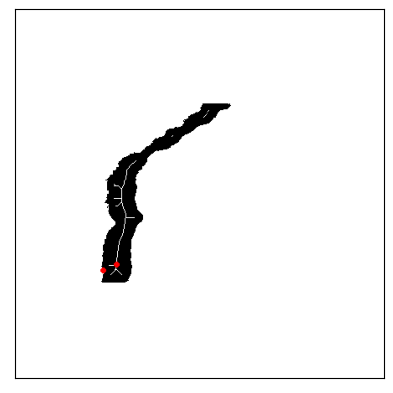

In [138]:
show_img(result.float().unsqueeze(0))